# Thresholding (Global vs. Adaptiv)



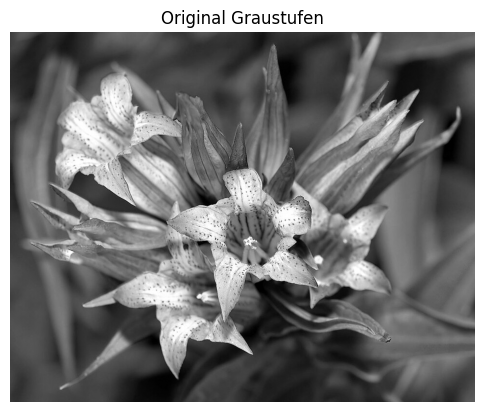

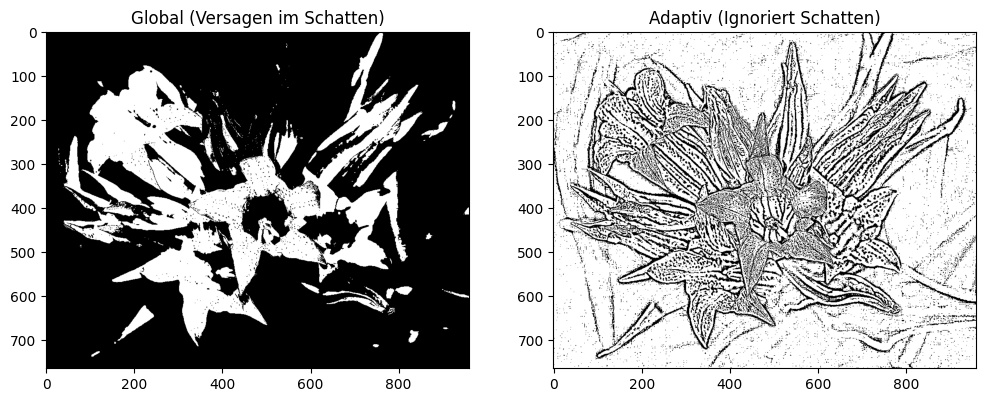

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_shadow = cv2.imread('Gentiana_asclepiadea_gray2.jpg', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(6, 6))
plt.imshow(img_shadow, cmap='gray')
plt.title("Original Graustufen")
plt.axis("off")
plt.show()


# 1. Globales Thresholding (Standard)
# Wir versuchen einen Wert zu raten, z.B. 127, oder anhand des Histogramms zu bestimmen
ret, th_global = cv2.threshold(img_shadow, 127, 255, cv2.THRESH_BINARY)

# 2. Adaptive Thresholding (Die Lösung für Schatten)
# Parameter: Bild, MaxVal, Methode (Mean oder Gaussian), Type, BlockSize, C (Konstante, die abgezogen wird)
th_adaptive = cv2.adaptiveThreshold(img_shadow, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, 11, 2)

# Darstellung
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1); plt.imshow(th_global, cmap='gray'); plt.title("Global (Versagen im Schatten)")
plt.subplot(1, 2, 2); plt.imshow(th_adaptive, cmap='gray'); plt.title("Adaptiv (Ignoriert Schatten)")
plt.show()

# Kantendetektion (Sobel vs. Canny)

Hier schauen wir uns an, wie Sobel die Richtungen findet und Canny das saubere Ergebnis liefert.


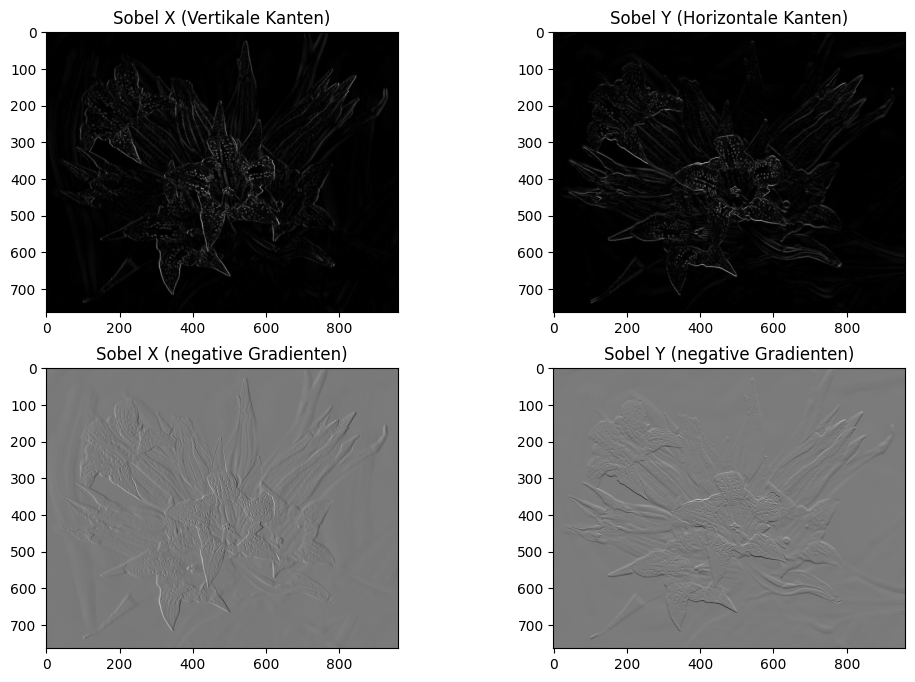

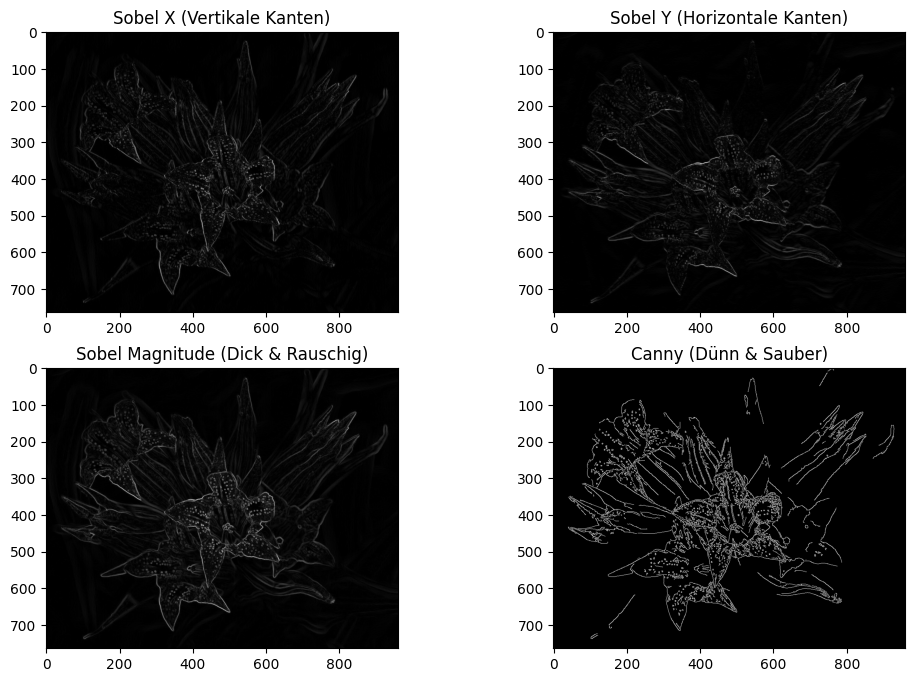

In [3]:

# Wir nehmen das adaptive Bild oder das Original
img = img_shadow

# 1. Sobel (Gradienten berechnen)
# cv2.CV_64F ist wichtig! Wir brauchen Float-Werte, da Gradienten negativ sein können (von Weiß nach Schwarz).
sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3) # Ableitung nach x (Vertikale Kanten)
sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3) # Ableitung nach y (Horizontale Kanten)

# Betrag berechnen (Magnitude)
sobel_combined = cv2.magnitude(sobel_x, sobel_y)


# Darstellung
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1); plt.imshow(np.abs(sobel_x), cmap='gray'); plt.title("Sobel X (Vertikale Kanten)")
plt.subplot(2, 2, 2); plt.imshow(np.abs(sobel_y), cmap='gray'); plt.title("Sobel Y (Horizontale Kanten)")
plt.subplot(2, 2, 3); plt.imshow((sobel_x), cmap='gray'); plt.title("Sobel X (negative Gradienten)")
plt.subplot(2, 2, 4); plt.imshow((sobel_y), cmap='gray'); plt.title("Sobel Y (negative Gradienten)")

plt.show()


# 2. Canny Edge Detector
# Argumente: Bild, MinThreshold, MaxThreshold
canny = cv2.Canny(img, 100, 200)

# Darstellung
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1); plt.imshow(np.abs(sobel_x), cmap='gray'); plt.title("Sobel X (Vertikale Kanten)")
plt.subplot(2, 2, 2); plt.imshow(np.abs(sobel_y), cmap='gray'); plt.title("Sobel Y (Horizontale Kanten)")
plt.subplot(2, 2, 3); plt.imshow(sobel_combined, cmap='gray'); plt.title("Sobel Magnitude (Dick & Rauschig)")
plt.subplot(2, 2, 4); plt.imshow(canny, cmap='gray'); plt.title("Canny (Dünn & Sauber)")

plt.show()



# Frage:  Warum brauchen wir zwei Schwellenwerte bei Canny?

## ACHTUNG Spoiler

Hysterese. Um zu verhindern, dass eine Kante "zerbröckelt" oder Lücken bekommt, wenn der Gradient leicht schwankt.
Wir akzeptieren schwache Kantenstücke nur, wenn sie mit starken verbunden sind.

# Region Growing vs. Thresholding:

Erklären Sie, dass Thresholding keine räumliche Information nutzt (Pixel 100 und Pixel 10000 werden gleich behandelt).

Region Growing hingegen nutzt die räumliche Nachbarschaft.

# Region Growing (Flood Fill)

OpenCV hat keine direkte region_growing Funktion, aber floodFill ist genau das: Ein Region Growing Algorithmus, der bei einem Seed-Punkt startet und ähnliche Nachbarn füllt.


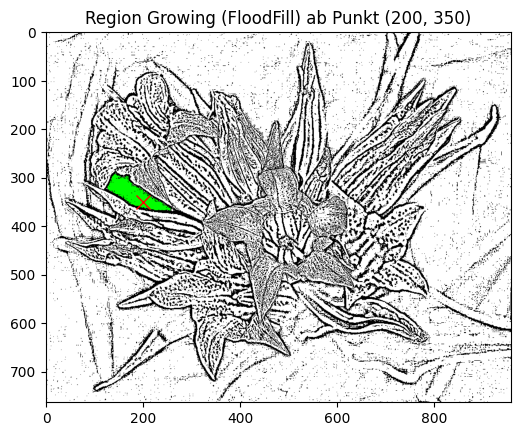

In [4]:
# Szenario: Wir wollen das Innere einer Blüte oder eine Form "ausmalen".

# Wir nehmen das binäre adaptive Bild
# WICHTIG: .copy() nutzen, da floodFill das Bild direkt verändert!
img_reg = th_adaptive.copy()

# Konvertierung zu BGR, damit wir das Ergebnis farbig markieren können
img_reg_color = cv2.cvtColor(img_reg, cv2.COLOR_GRAY2BGR)

# Maske wird für FloodFill benötigt (muss 2 Pixel größer sein als das Bild)
# Der Algorithmus braucht intern einen 1-Pixel-Rand um das Bild, um "Rand-Checks" zu vermeiden (Boundary Conditions).
# Das ist ein technisches Implementierungsdetail von OpenCV C++.
h, w = img_reg.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

# Seed Point wählen (z.B. irgendwo links oben im weißen Bereich)
# In einer echten App würde das per Mausklick passieren
seed_point = (200, 350)

# Farbe für den Füllbereich (Grün)
new_color = (0, 255, 0)

# FloodFill ausführen
# Parameter: Bild, Maske, Seed, Neue Farbe, Toleranz unten, Toleranz oben
# loDiff und upDiff geben an, wie stark die Helligkeit je Farbkanal abweichen darf
cv2.floodFill(img_reg_color, mask, seed_point, new_color, loDiff=(5,5,5), upDiff=(5,5,5))

plt.figure(figsize=(6, 6))
plt.imshow(img_reg_color)
# Markieren des Startpunkts
plt.plot(seed_point[0], seed_point[1], 'rx', markersize=10)
plt.title(f"Region Growing (FloodFill) ab Punkt {seed_point}")
plt.show()

Echtes Region Growing muss manuell implementiert werden.

In [5]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

def region_growing(img, seed, threshold):
    """
    Führt Region Growing auf einem Graustufenbild aus.

    Args:
        img (numpy.ndarray): 2D Input Bild (Graustufen).
        seed (tuple): Startpunkt (x, y) bzw. (col, row).
        threshold (int/float): Max erlaubte Differenz zum Seed-Wert.

    Returns:
        numpy.ndarray: Binärmaske der segmentierten Region.
    """
    rows, cols = img.shape
    x_seed, y_seed = seed

    # Sicherheitscheck: Ist Seed im Bild?
    if not (0 <= x_seed < cols and 0 <= y_seed < rows):
        raise ValueError("Seed-Punkt liegt außerhalb des Bildes.")

    # Datenstrukturen initialisieren
    segmentation_mask = np.zeros_like(img, dtype=np.uint8)
    visited = np.zeros_like(img, dtype=np.bool_)

    # Intensität des Seed-Points holen
    # Achtung: numpy ist [row, col], also [y, x]
    seed_intensity = float(img[y_seed, x_seed])

    # Queue initialisieren (BFS Ansatz)
    queue = deque([seed])
    visited[y_seed, x_seed] = True

    # Nachbarschafts-Definition (4er-Nachbarschaft: Oben, Unten, Links, Rechts)
    # Für 8er-Nachbarschaft einfach die Diagonalen hinzufügen
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    while queue:
        cx, cy = queue.popleft()

        # Pixel zur Region hinzufügen
        segmentation_mask[cy, cx] = 255

        # Nachbarn überprüfen
        for dx, dy in neighbors:
            nx, ny = cx + dx, cy + dy

            # 1. Check: Innerhalb der Bildgrenzen?
            if 0 <= nx < cols and 0 <= ny < rows:
                # 2. Check: Schon besucht?
                if not visited[ny, nx]:
                    # 3. Check: Homogenitätskriterium (Intensitätsdifferenz)
                    current_val = float(img[ny, nx])
                    if abs(current_val - seed_intensity) <= threshold:
                        visited[ny, nx] = True
                        queue.append((nx, ny))

    return segmentation_mask



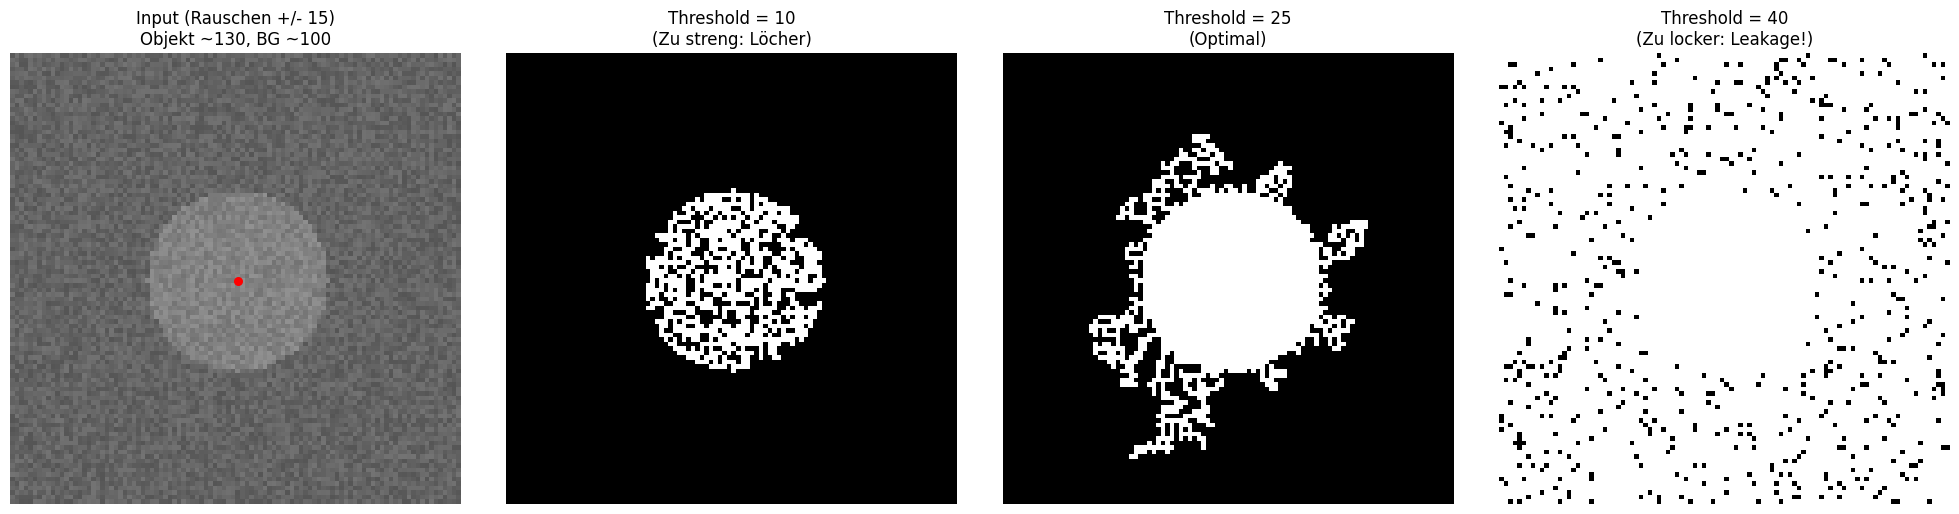

In [6]:
def test_leakage_scenario():
    # --- 1. Komplexeres Bild erstellen ---
    size = 100
    # Hintergrund: Grau (Intensität 100)
    img = np.ones((size, size), dtype=np.float32) * 100

    # Objekt: Ein Kreis in der Mitte (Intensität 130)
    # Geringer Kontrast: Nur 30 Differenz zum Hintergrund!
    y, x = np.ogrid[:size, :size]
    center = (50, 50)
    mask_circle = ((x - center[0])**2 + (y - center[1])**2) <= 20**2
    img[mask_circle] = 130

    # Starkes Rauschen hinzufügen (+/- 15)
    # Das macht die Trennung schwer, da 100+15=115 (Hintergrund-Max)
    # und 130-15=115 (Objekt-Min) sich berühren.
    noise = np.random.randint(-15, 16, (size, size))
    img_noisy = np.clip(img + noise, 0, 255).astype(np.uint8)

    seed = (50, 50) # Mitte des Kreises

    # --- 2. Testläufe mit verschiedenen Thresholds ---

    # Fall A: Zu streng (Konservativ)
    # Threshold 10 ist kleiner als das Rauschen (15).
    # Erwartung: Die Region wächst nicht vollständig, viele Löcher.
    mask_strict = region_growing(img_noisy, seed, threshold=10)

    # Fall B: Zu locker (Leakage)
    # Threshold 40 erlaubt Differenzen bis 130 +/- 40 -> 90 bis 170.
    # Der Hintergrund hat ca. 100. Das liegt im Bereich!
    # Erwartung: Die Region bricht aus und flutet den Hintergrund.
    mask_loose = region_growing(img_noisy, seed, threshold=40)

    # Fall C: Optimal (Sweet Spot)
    # Threshold 25 deckt das Rauschen ab (15), aber sperrt den Hintergrund aus.
    mask_optimal = region_growing(img_noisy, seed, threshold=25)

    # --- 3. Visualisierung ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Originalbild mit Seed
    axes[0].imshow(img_noisy, cmap='gray', vmin=0, vmax=255)
    axes[0].scatter([seed[0]], [seed[1]], c='red', s=30)
    axes[0].set_title(f"Input (Rauschen +/- 15)\nObjekt ~130, BG ~100")

    # Zu streng
    axes[1].imshow(mask_strict, cmap='gray')
    axes[1].set_title("Threshold = 10\n(Zu streng: Löcher)")

    # Optimal
    axes[2].imshow(mask_optimal, cmap='gray')
    axes[2].set_title("Threshold = 25\n(Optimal)")

    # Leakage
    axes[3].imshow(mask_loose, cmap='gray')
    axes[3].set_title("Threshold = 40\n(Zu locker: Leakage!)")

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    test_leakage_scenario()

# Morphologische Operationen (Aufräumen)

### Szenario: Unsere Segmentierung (z.B. Canny oder Threshold) ist "schmutzig".

Wir wollen Rauschen entfernen und Lücken schließen.


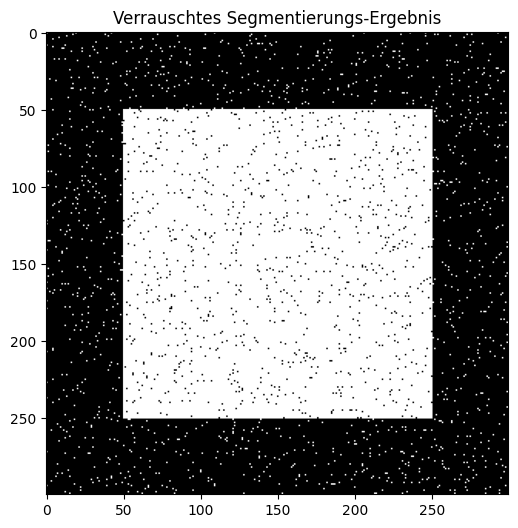

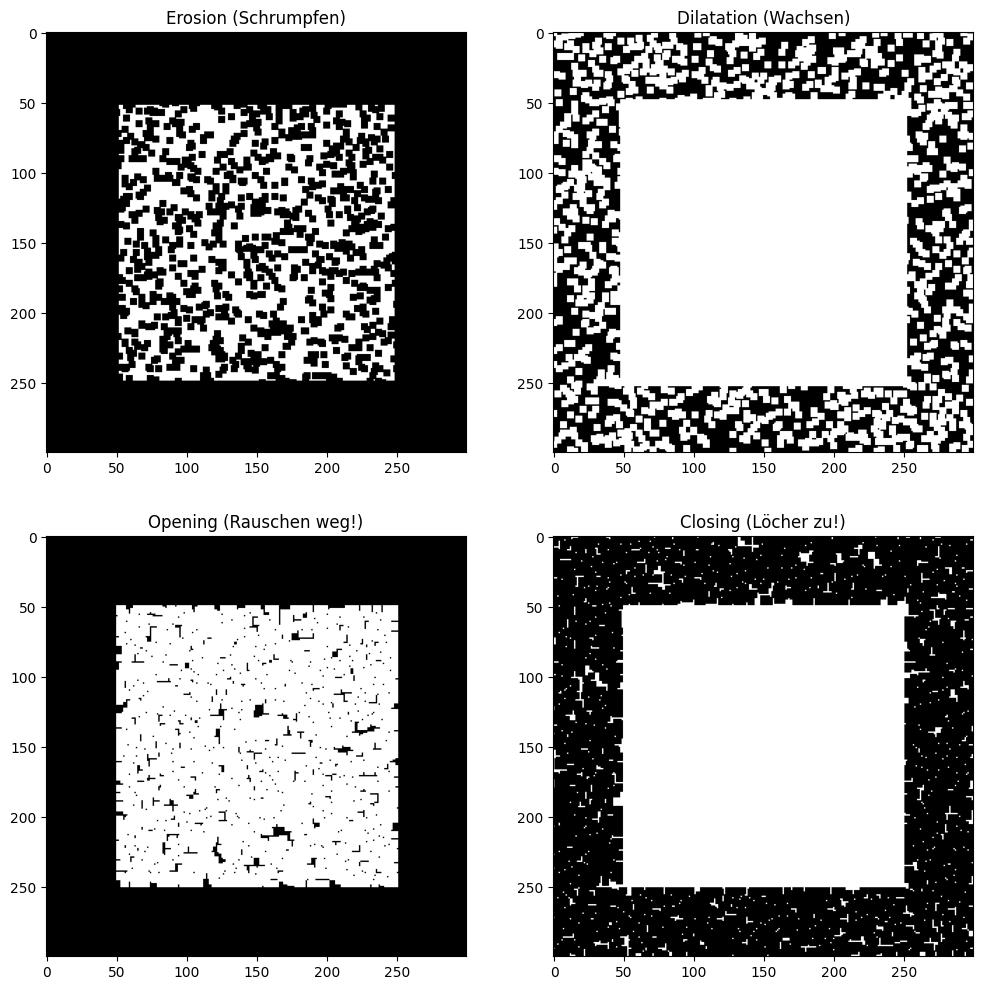

In [7]:
# Wir erzeugen ein verrauschtes Binärbild zum Testen
# Ein weißes Rechteck auf schwarzem Grund mit "Salz und Pfeffer" Rauschen
noisy_img = np.zeros((300, 300), dtype="uint8")
cv2.rectangle(noisy_img, (50, 50), (250, 250), 255, -1) # Das Objekt

# Rauschen hinzufügen (Weiße Punkte im Hintergrund, Schwarze Punkte im Objekt)
noise = np.random.randint(0, 2, (300, 300)) * 255
mask_noise = np.random.rand(300, 300) > 0.95 # 5% Rauschen
noisy_img[mask_noise] = noise[mask_noise]

plt.figure(figsize=(6,6))
plt.imshow(noisy_img, cmap='gray')
plt.title("Verrauschtes Segmentierungs-Ergebnis")
plt.show()

# Definition des Kernels (Strukturelement)
# Ein 5x5 Quadrat aus Einsen
kernel = np.ones((5,5), np.uint8)

# 1. Erosion (Rauschen entfernen, aber Objekt schrumpft)
erosion = cv2.erode(noisy_img, kernel, iterations=1)

# 2. Dilatation (Löcher stopfen, aber Rauschen wächst)
dilation = cv2.dilate(noisy_img, kernel, iterations=1)

# 3. Opening (Erosion -> Dilatation)
# Der Goldstandard um weiße Punkte im Hintergrund zu entfernen!
opening = cv2.morphologyEx(noisy_img, cv2.MORPH_OPEN, kernel)

# 4. Closing (Dilatation -> Erosion)
# Der Goldstandard um schwarze Löcher im Objekt zu schließen!
closing = cv2.morphologyEx(noisy_img, cv2.MORPH_CLOSE, kernel)

# Darstellung
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1); plt.imshow(erosion, cmap='gray'); plt.title("Erosion (Schrumpfen)")
plt.subplot(2, 2, 2); plt.imshow(dilation, cmap='gray'); plt.title("Dilatation (Wachsen)")
plt.subplot(2, 2, 3); plt.imshow(opening, cmap='gray'); plt.title("Opening (Rauschen weg!)")
plt.subplot(2, 2, 4); plt.imshow(closing, cmap='gray'); plt.title("Closing (Löcher zu!)")
plt.show()



# LERNZIEL:

- Opening eignet sich perfekt, um kleine Störungen im Hintergrund zu löschen.
- Closing eignet sich perfekt, um ein Objekt "kompakt" zu machen.

# Filterprozesse

## Räumliche Filter (Ortsraum)

### Rauschunterdrückung durch Tiefpassfilter

Bilder enthalten oft Rauschen oder feine Details, die für eine Segmentierung stören können. Ein Tiefpassfilter "glättet" das Bild, indem er hohe Frequenzen (schnelle Änderungen der Helligkeit) abschwächt.

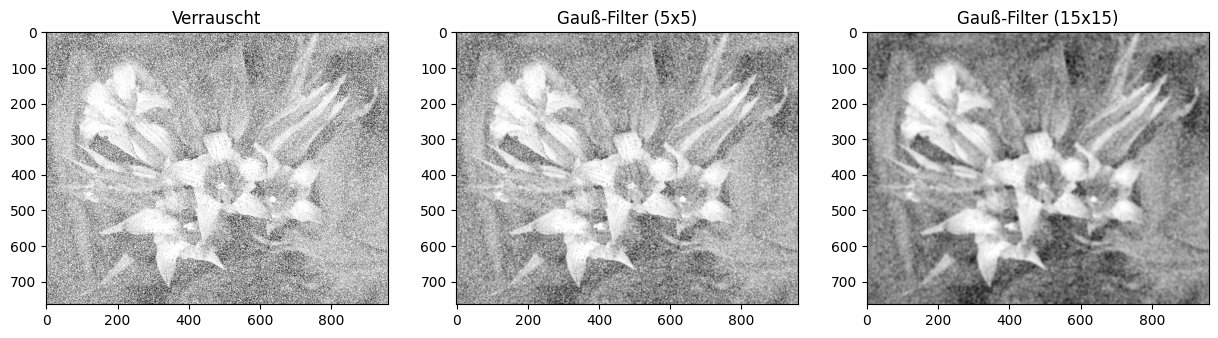

In [8]:
# 1. Rauschen hinzufügen (optional zur Demonstration)
noise = np.random.normal(0, 25, img_shadow.shape).astype(np.uint8)
img_noisy = cv2.add(img_shadow, noise)

# 2. Tiefpassfilter (Gauß) anwenden
# Parameter: (Bild, Kernel-Größe, Standardabweichung)
img_blur_small = cv2.GaussianBlur(img_noisy, (5, 5), 0)
img_blur_large = cv2.GaussianBlur(img_noisy, (15, 15), 0)

# Darstellung
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(img_noisy, cmap='gray'); plt.title("Verrauscht")
plt.subplot(1, 3, 2); plt.imshow(img_blur_small, cmap='gray'); plt.title("Gauß-Filter (5x5)")
plt.subplot(1, 3, 3); plt.imshow(img_blur_large, cmap='gray'); plt.title("Gauß-Filter (15x15)")
plt.show()

### Kantendetektion durch Hochpassfilter

Um Objekte zu segmentieren, sind oft die Ränder (Kanten) entscheidend. Ein Hochpassfilter betont schnelle Helligkeitswechsel und unterdrückt homogene Flächen.

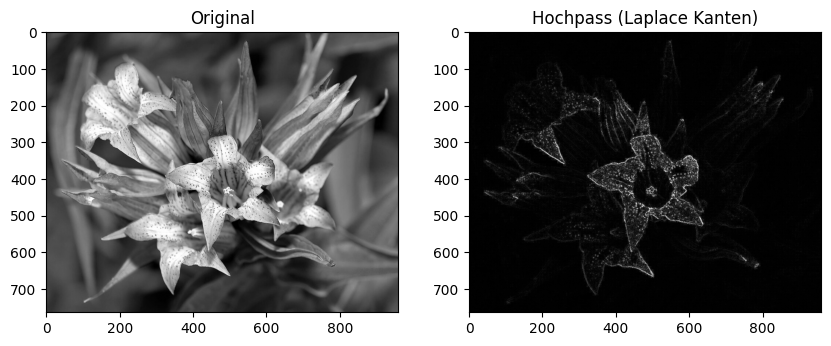

In [9]:
# Laplace-Filter zur Kantenerkennung
# ddepth=cv2.CV_64F ist wichtig, um negative Werte zu behalten (Übergang hell->dunkel)
laplacian = cv2.Laplacian(img_shadow, cv2.CV_64F)

# Absolutbetrag nehmen und in uint8 konvertieren für die Anzeige
laplacian_abs = cv2.convertScaleAbs(laplacian)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(img_shadow, cmap='gray'); plt.title("Original")
plt.subplot(1, 2, 2); plt.imshow(laplacian_abs, cmap='gray'); plt.title("Hochpass (Laplace Kanten)")
plt.show()

## Frequenzraum (Fourier-Transformation)

### Analyse im Frequenzraum (FFT)

Jedes Bild kann als Überlagerung von Wellen dargestellt werden. Die Fouriertransformation (FFT) zeigt uns, welche Frequenzen im Bild dominieren.

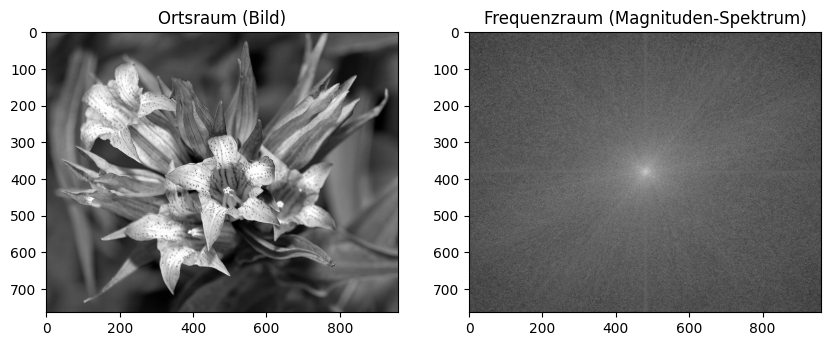

In [10]:
# 1. FFT durchführen
f = np.fft.fft2(img_shadow)
fshift = np.fft.fftshift(f) # Nullfrequenz in die Mitte schieben

# 2. Magnituden-Spektrum für die Anzeige (logarithmische Skalierung)
magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1) # +1 um log(0) zu vermeiden

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(img_shadow, cmap='gray'); plt.title("Ortsraum (Bild)")
plt.subplot(1, 2, 2); plt.imshow(magnitude_spectrum, cmap='gray'); plt.title("Frequenzraum (Magnituden-Spektrum)")
plt.show()

### Filterung im Frequenzraum (Idealer Tiefpass)

Wir können Filteroperationen (wie in Aufgabe 1) auch direkt im Frequenzraum durchführen, indem wir bestimmte Frequenzen "löschen". Ein Tiefpass im Frequenzraum lässt nur die niedrigen Frequenzen (die Mitte) passieren.

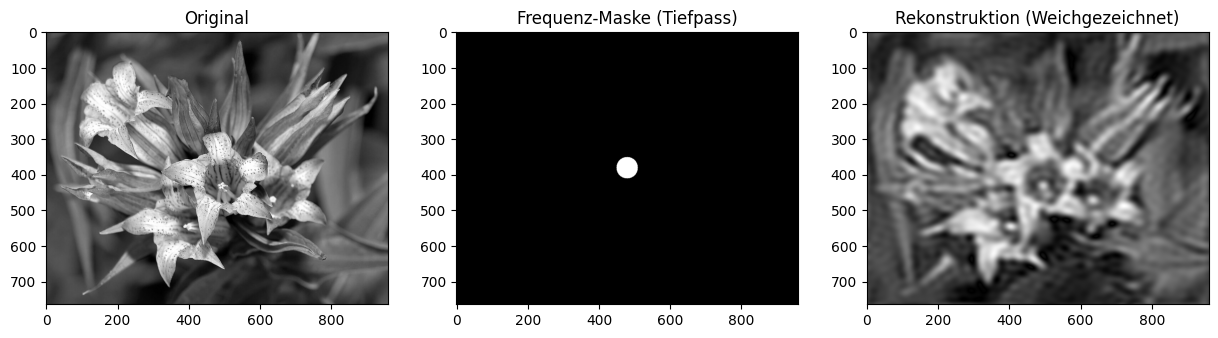

In [13]:
rows, cols = img_shadow.shape
crow, ccol = rows//2, cols//2  # Mittelpunkt

# 1. Maske erstellen (Idealer Tiefpass: Kreis in der Mitte)
# Radius bestimmt, wie stark weichgezeichnet wird (kleiner Radius = mehr Blur)
radius = 30
mask = np.zeros((rows, cols), np.uint8)
# Kreisfläche auf 1 setzen
cv2.circle(mask, (ccol, crow), radius, 1, -1)

# 2. Filterung anwenden (Frequenzen ausblenden)
fshift_filtered = fshift * mask

# 3. Rücktransformation (Inverse FFT)
f_ishift = np.fft.ifftshift(fshift_filtered)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back) # Betrag nehmen (da Ergebnis komplex sein kann)

# Darstellung
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(img_shadow, cmap='gray'); plt.title("Original")
plt.subplot(1, 3, 2); plt.imshow(mask, cmap='gray'); plt.title("Frequenz-Maske (Tiefpass)")
plt.subplot(1, 3, 3); plt.imshow(img_back, cmap='gray'); plt.title("Rekonstruktion (Weichgezeichnet)")
plt.show()

### Kantenextraktion durch Hochpassfilter im Frequenzraum

Während der Tiefpassfilter nur die niedrigen Frequenzen (Mitte) durchlässt und somit das Bild weichzeichnet, macht der Hochpassfilter genau das Gegenteil. Er blockiert die niedrigen Frequenzen in der Mitte und lässt nur die hohen Frequenzen (außen) passieren. Da hohe Frequenzen schnelle Bildänderungen repräsentieren, bleiben nach der Rücktransformation nur die Kanten und feinen Details übrig.

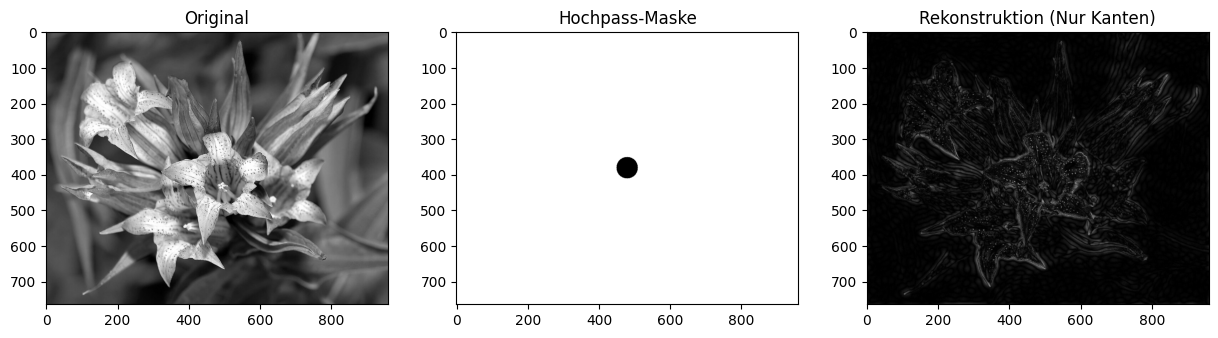

In [14]:
# Wir verwenden wieder die Dimensionen und den Mittelpunkt aus den vorherigen Aufgaben
rows, cols = img_shadow.shape
crow, ccol = rows//2, cols//2

# 1. Hochpass-Maske erstellen (Ideal High Pass)
# Initialisieren mit Einsen (alles durchlassen)
mask_hp = np.ones((rows, cols), np.uint8)
# Die Mitte (tiefe Frequenzen) auf Null setzen (blockieren)
radius = 30
cv2.circle(mask_hp, (ccol, crow), radius, 0, -1)

# 2. Filterung anwenden
fshift_filtered_hp = fshift * mask_hp

# 3. Rücktransformation (Inverse FFT)
f_ishift_hp = np.fft.ifftshift(fshift_filtered_hp)
img_back_hp = np.fft.ifft2(f_ishift_hp)
img_back_hp = np.abs(img_back_hp) # Betrag bilden

# Darstellung
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(img_shadow, cmap='gray'); plt.title("Original")
plt.subplot(1, 3, 2); plt.imshow(mask_hp, cmap='gray'); plt.title("Hochpass-Maske")
plt.subplot(1, 3, 3); plt.imshow(img_back_hp, cmap='gray'); plt.title("Rekonstruktion (Nur Kanten)")
plt.show()